### This notebook creates timeseries of the total ASC transport at select locations along the slope for the CM4-X high resolution hierarchy for the piControl, historical, and SSP5-85 experiment. We only present the results for the  most recent p25 and p125 interations (p125: Odiv-209, 233 ; p25: Odiv-230, 231, Odiv-231-ssp585). The details for all configurations developed are summarized below.

## __Summary of CM4 high-res configuration development__

#### __Odiv-183__: p125, c192. Remap scheme PPM_H4 initialized from year 0. Sea ice initial conditions based on year 100 of v3 rather than year 150.
#### __Odiv-184__: p125, c192. Remap scheme PPM_H4 initialized from year 0.
#### __Odiv-170__: p25, c192. Remap scheme PPM_H4 initialized from year 0.
#### __Odiv-191__: p125, c192. Initialized like Odiv-183/184, remap scheme = P1M_H2, submeso MLE decay time = 10 days. Used as baseline experiment to then tune submeso.
#### __Odiv-200__: p125, c192. Sensitivity of submeso parameterization, submeso MLE decay time = 20 days, with everything else the same as Odiv-191
#### __Odiv-206__: p125, c192. Sensitivity experiment with CM4.0 sea ice albedos initialized from year 180 of Odiv-200 run. 
#### __Odiv-207__: p125, c192. Sensitivity experiment with same sea ice albedos as Odiv-206 but with ESM4 snow-on-land albedos values.
#### __Odiv-209__: p125, c192. Same as Odiv-207 but initialized from year 0.

###### _Most recent p25 iterations:_
#### __Odiv-210__: p25, c192. Complete 350 years of p25 piControl with an older code and Arctic bug.
#### __Odiv-230__: p25, c192. Rerun of piControl with newer model code and Arctic bug fix, starting from year 100 of Odiv-210
#### __Odiv-231__: p25, c192. Historical run starting from year 100 of Odiv-210
#### __Odiv-232__: p25, c192. SSP5-85 scenario starting from year 2014 of Odiv-231

###### _Most recent p125 iterations:_
#### __Odiv-209__: Same as above .... 350 years piControl
#### __Odiv-233__: p125, c192. Historical run starting from year 100 of Odiv-209.



##### Note: A longer MLE decay time means the submeso MLE scheme hangs around longer to __more strongly effect restratification__. We adjusted to T=20 days (doubled the decay time) from Odiv-191 to Odiv-200 because we wanted stronger ML restratification to cool the model since we are running an 1850 piControl. In CM4-CMIP6, MLE T=30 days. Another "tunable" submesoscale parameter is MLE front-length scale ... a __smaller__ front length enhances the strength of the ML restratificaion. ESM4 used 200m, CM4 used 500m. All Odiv members use length = 500 m, this has not been adjusted.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import numpy as np
import xgcm
from xgcm import Grid
import momlevel as ml
import pandas as pd
import sectionate

Matplotlib is building the font cache; this may take a moment.


### Load all necessary datasets:

In [3]:
def load_ocean_asc(model_config):
    
    ## p125 configurations
    
    ##### CONTROL RUN - 1
    if model_config == 'Odiv-209':
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True, chunks={'time':10,'z_l':1})
    
    #### CONTROL RUN - 2
    if model_config == 'Odiv-313':
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_piControl_c192_OM4p125_v8/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc',
        combine='by_coords', use_cftime=True, chunks={'time':10,'z_l':1})
        
    ##### HISTORICAL RUN (branches from year 100 of Odiv-209 piControl).
    ##### ODiv-233 only goes to 1939
    if model_config == 'Odiv-233':
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p125/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True, chunks={'time':10,'z_l':1})
        
    if model_config == 'Odiv-255':
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
        
    ##### SSP5-85
    if model_config == 'Odiv-293':
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_ssp585_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
        
        
    ###############################################
    
    ## p25 configurations
         
    if model_config == 'Odiv-210':
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p25_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True, chunks={'time':10,'z_l':1})
    
    ##### piControl with Arctic bug fix Year 101
    if model_config == 'Odiv-230':
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True, chunks={'time':10,'z_l':1})
        
    ##### HISTORICAL RUN
    if model_config == 'Odiv-231':
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True, chunks={'time':10,'z_l':1})
    
    ##### SSP5-85
    if model_config == 'Odiv-231-ssp585':
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_ssp585_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True, chunks={'time':10,'z_l':1})
        
    return ds_umo

## Load p125 datasets and limit slices to south of 60S

In [4]:
odiv_209 = load_ocean_asc('Odiv-209').sel(yh=slice(-80,-60)).sel(time=slice('0001-01-16','0100-12-16'))
odiv_313 = load_ocean_asc('Odiv-313').sel(yh=slice(-80,-60)).sel(time=slice('0101-01-16','0350-12-16'))
odiv_233 = load_ocean_asc('Odiv-233').sel(yh=slice(-80,-60))
odiv_255 = load_ocean_asc('Odiv-255').sel(yh=slice(-80,-60))
odiv_293 = load_ocean_asc('Odiv-293').sel(yh=slice(-80,-60))

## Load p25 datasets and limit slices to south of 60S

In [5]:
odiv_210 = load_ocean_asc('Odiv-210').sel(yh=slice(-80,-60)).sel(time=slice('0001-01-16','0100-12-16'))
odiv_230 = load_ocean_asc('Odiv-230').sel(yh=slice(-80,-60)).sel(time=slice('0101-01-16','0350-12-16'))
odiv_231 = load_ocean_asc('Odiv-231').sel(yh=slice(-80,-60))
odiv_231_SSP585 = load_ocean_asc('Odiv-231-ssp585').sel(yh=slice(-80,-60))

### Load static fields

In [6]:
static_om4p125 = xr.open_dataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc')
static_om4p25 = xr.open_dataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc')

In [24]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster 

portdash=19131

cluster = SLURMCluster(
    queue="analysis",
    cores=1,
    project="gfdl_o",
    job_extra=["-C bigmem"],
    memory="128GB",
    walltime="04:00:00",
    scheduler_options={"dashboard_address":f'{portdash}'},
)

client=Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://140.208.147.175:19131/status,
Dashboard: http://140.208.147.175:19131/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://140.208.147.175:46381,Workers: 0
Dashboard: http://140.208.147.175:19131/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [26]:
cluster.scale(10)

## Use sectionate to find the cross sections for each model configuration

In [27]:
## Use sectionate to find the cross section closest to 20E for each model configuration
## 20E
lat20e_coast = -70.5
lon20e_coast = 20
lat20e_offshore = -68
lon20e_offshore = 20
## 150E
lat150e_coast = -69
lon150e_coast = -210
lat150e_offshore = -65.2
lon150e_offshore = -210
## 130W
lat130w_coast = -75
lon130w_coast = -130
lat130w_offshore = -72
lon130w_offshore = -130
## 80W
lat80w_coast = -74
lon80w_coast = -80
lat80w_offshore = -68
lon80w_offshore = -80

isec_20e_p125, jsec_20e_p125, xsec_20e_p125, ysec_20e_p125 = sectionate.create_section(static_om4p125['geolon_u'],static_om4p125['geolat_u'],lon20e_coast,lat20e_coast,lon20e_offshore,lat20e_offshore)
isec_150e_p125, jsec_150e_p125, xsec_150e_p125, ysec_150e_p125 = sectionate.create_section(static_om4p125['geolon_u'],static_om4p125['geolat_u'],lon150e_coast,lat150e_coast,lon150e_offshore,lat150e_offshore)
isec_130w_p125, jsec_130w_p125, xsec_130w_p125, ysec_130w_p125 = sectionate.create_section(static_om4p125['geolon_u'],static_om4p125['geolat_u'],lon130w_coast,lat130w_coast,lon130w_offshore,lat130w_offshore)
isec_80w_p125, jsec_80w_p125, xsec_80w_p125, ysec_80w_p125 = sectionate.create_section(static_om4p125['geolon_u'],static_om4p125['geolat_u'],lon80w_coast,lat80w_coast,lon80w_offshore,lat80w_offshore)

isec_20e_p25, jsec_20e_p25, xsec_20e_p25, ysec_20e_p25 = sectionate.create_section(static_om4p25['geolon_u'],static_om4p25['geolat_u'],lon20e_coast,lat20e_coast,lon20e_offshore,lat20e_offshore)
isec_150e_p25, jsec_150e_p25, xsec_150e_p25, ysec_150e_p25 = sectionate.create_section(static_om4p25['geolon_u'],static_om4p25['geolat_u'],lon150e_coast,lat150e_coast,lon150e_offshore,lat150e_offshore)
isec_130w_p25, jsec_130w_p25, xsec_130w_p25, ysec_130w_p25 = sectionate.create_section(static_om4p25['geolon_u'],static_om4p25['geolat_u'],lon130w_coast,lat130w_coast,lon130w_offshore,lat130w_offshore)
isec_80w_p25, jsec_80w_p25, xsec_80w_p25, ysec_80w_p25 = sectionate.create_section(static_om4p25['geolon_u'],static_om4p25['geolat_u'],lon80w_coast,lat80w_coast,lon80w_offshore,lat80w_offshore)

### Find xq value with point closest to correct longitude for p125 configurations

In [28]:
xsec_20e_p125[0].xq.values,\
xsec_150e_p125[0].xq.values,\
xsec_130w_p125[0].xq.values,\
xsec_80w_p125[0].xq.values

(array(24.41054717),
 array(-215.20303921),
 array(-135.07166178),
 array(-76.39249697))

### Find xq value with point closest to correct longitude for p25 configurations

In [29]:
### find xq value with point closest to correct longitude
xsec_20e_p25[0].xq.values,\
xsec_150e_p25[0].xq.values,\
xsec_130w_p25[0].xq.values,\
xsec_80w_p25[0].xq.values

(array(20.50622247),
 array(-210.59139769),
 array(-130.49207101),
 array(-79.65569144))

### Compute timeseries at 20E

In [30]:
## p125 configurations
asc_20e_p125_cntrl_1 = odiv_209.umo.sel(yh=slice(-70.5,-68)).sel(xq=24.41,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_20e_p125_cntrl_2 = odiv_313.umo.sel(yh=slice(-70.5,-68)).sel(xq=24.41,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_20e_p125_hist1 = odiv_233.umo.sel(yh=slice(-70.5,-68)).sel(xq=24.41,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_20e_p125_hist2 = odiv_255.umo.sel(yh=slice(-70.5,-68)).sel(xq=24.41,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_20e_p125_SSP585 = odiv_293.umo.sel(yh=slice(-70.5,-68)).sel(xq=24.41,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6

## p25 configurations
asc_20e_p25_cntrl_1 = odiv_210.umo.sel(yh=slice(-70.5,-68)).sel(xq=20.51,method='nearest').squeeze().sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_20e_p25_cntrl_2 = odiv_230.umo.sel(yh=slice(-70.5,-68)).sel(xq=20.51,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_20e_p25_hist = odiv_231.umo.sel(yh=slice(-70.5,-68)).sel(xq=20.51,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_20e_p25_SSP585 = odiv_231_SSP585.umo.sel(yh=slice(-70.5,-68)).sel(xq=20.51,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6

### Compute timeseries at 150E

In [31]:
## p125 configurations
asc_150e_p125_cntrl_1 = odiv_209.umo.sel(yh=slice(-69,-65.2)).sel(xq=-215.20,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_150e_p125_cntrl_2 = odiv_313.umo.sel(yh=slice(-69,-65.2)).sel(xq=-215.20,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_150e_p125_hist1 = odiv_233.umo.sel(yh=slice(-69,-65.2)).sel(xq=-215.20,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_150e_p125_hist2 = odiv_255.umo.sel(yh=slice(-69,-65.2)).sel(xq=-215.20,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_150e_p125_SSP585 = odiv_293.umo.sel(yh=slice(-69,-65.2)).sel(xq=-215.20,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6

## p25 configurations
asc_150e_p25_cntrl_1 = odiv_210.umo.sel(yh=slice(-69,-65.2)).sel(xq=-210.59,method='nearest').squeeze().sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_150e_p25_cntrl_2 = odiv_230.umo.sel(yh=slice(-69,-65.2)).sel(xq=-210.59,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_150e_p25_hist = odiv_231.umo.sel(yh=slice(-69,-65.2)).sel(xq=-210.59,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_150e_p25_SSP585 = odiv_231_SSP585.umo.sel(yh=slice(-69,-65.2)).sel(xq=-210.59,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6

### Compute timeseries at 130W

In [32]:
## p125 configurations
asc_130w_p125_cntrl_1 = odiv_209.umo.sel(yh=slice(-75,-72)).sel(xq=-135.07,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_130w_p125_cntrl_2 = odiv_313.umo.sel(yh=slice(-75,-72)).sel(xq=-135.07,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_130w_p125_hist1 = odiv_233.umo.sel(yh=slice(-75,-72)).sel(xq=-135.07,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_130w_p125_hist2 = odiv_255.umo.sel(yh=slice(-75,-72)).sel(xq=-135.07,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_130w_p125_SSP585 = odiv_293.umo.sel(yh=slice(-75,-72)).sel(xq=-135.07,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6

## p25 configurations
asc_130w_p25_cntrl_1 = odiv_210.umo.sel(yh=slice(-75,-72)).sel(xq=-130.49,method='nearest').squeeze().sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_130w_p25_cntrl_2 = odiv_230.umo.sel(yh=slice(-75,-72)).sel(xq=-130.49,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_130w_p25_hist = odiv_231.umo.sel(yh=slice(-75,-72)).sel(xq=-130.49,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_130w_p25_SSP585 = odiv_231_SSP585.umo.sel(yh=slice(-75,-72)).sel(xq=-130.49,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6

### Compute timeseries at 80W

In [33]:
## p125 configurations
asc_80W_p125_cntrl_1 = odiv_209.umo.sel(yh=slice(-74,-68)).sel(xq=-76.39,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_80W_p125_cntrl_2 = odiv_313.umo.sel(yh=slice(-74,-68)).sel(xq=-76.39,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_80W_p125_hist1 = odiv_233.umo.sel(yh=slice(-74,-68)).sel(xq=-76.39,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_80W_p125_hist2 = odiv_255.umo.sel(yh=slice(-74,-68)).sel(xq=-76.39,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_80W_p125_SSP585 = odiv_293.umo.sel(yh=slice(-74,-68)).sel(xq=-76.39,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6

## p25 configurations
asc_80W_p25_cntrl_1 = odiv_210.umo.sel(yh=slice(-74,-68)).sel(xq=-79.66,method='nearest').squeeze().sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_80W_p25_cntrl_2 = odiv_230.umo.sel(yh=slice(-74,-68)).sel(xq=-79.66,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_80W_p25_hist = odiv_231.umo.sel(yh=slice(-74,-68)).sel(xq=-79.66,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6
asc_80W_p25_SSP585 = odiv_231_SSP585.umo.sel(yh=slice(-74,-68)).sel(xq=-79.66,method='nearest').sum(dim=['yh','z_l'])*(1/1035)*1e-6

### Concatenate 210 and 230 along time dimension for all sections

In [34]:
asc_20e_p25_cntrl = xr.concat([asc_20e_p25_cntrl_1,asc_20e_p25_cntrl_2],dim='time').sel(time=slice('0001-07-02','0350-07-02'))
asc_150e_p25_cntrl = xr.concat([asc_150e_p25_cntrl_1,asc_150e_p25_cntrl_2],dim='time').sel(time=slice('0001-07-02','0350-07-02'))
asc_130w_p25_cntrl = xr.concat([asc_130w_p25_cntrl_1,asc_130w_p25_cntrl_2],dim='time').sel(time=slice('0001-07-02','0350-07-02'))
asc_80W_p25_cntrl = xr.concat([asc_80W_p25_cntrl_1,asc_80W_p25_cntrl_2],dim='time').sel(time=slice('0001-07-02','0350-07-02'))

In [35]:
asc_20e_p125_cntrl = xr.concat([asc_20e_p125_cntrl_1,asc_20e_p125_cntrl_2],dim='time').sel(time=slice('0001-07-02','0350-07-02'))
asc_150e_p125_cntrl = xr.concat([asc_150e_p125_cntrl_1,asc_150e_p125_cntrl_2],dim='time').sel(time=slice('0001-07-02','0350-07-02'))
asc_130w_p125_cntrl = xr.concat([asc_130w_p125_cntrl_1,asc_130w_p125_cntrl_2],dim='time').sel(time=slice('0001-07-02','0350-07-02'))
asc_80W_p125_cntrl = xr.concat([asc_80W_p125_cntrl_1,asc_80W_p125_cntrl_2],dim='time').sel(time=slice('0001-07-02','0350-07-02'))

### Set time axis labels for plotting from year 1750 to 2100

In [36]:
## for piControl -- both
time_axis_1750_2100 = pd.date_range("1750","2100",freq='Y')
## for odiv-231 ... historical p25
time_axis_1850_2010 = pd.date_range("1850","2010",freq='Y')

## for odiv-233 -- historical 1
time_axis_1850_1939 = pd.date_range("1850","1940",freq='Y')
## for odiv-255 -- historical 2
time_axis_1850_2015 = pd.date_range("1850","2015",freq='Y')
## for odiv-231, SSP5-85
time_axis_2010_2100 = pd.date_range("2010","2100",freq='Y')
## for odiv-293, p125 SSP5-85
time_axis_2015_2100 = pd.date_range("2015","2100",freq='Y')

In [37]:
time_axis_1850_2015

DatetimeIndex(['1850-12-31', '1851-12-31', '1852-12-31', '1853-12-31',
               '1854-12-31', '1855-12-31', '1856-12-31', '1857-12-31',
               '1858-12-31', '1859-12-31',
               ...
               '2005-12-31', '2006-12-31', '2007-12-31', '2008-12-31',
               '2009-12-31', '2010-12-31', '2011-12-31', '2012-12-31',
               '2013-12-31', '2014-12-31'],
              dtype='datetime64[ns]', length=165, freq='A-DEC')

In [38]:
asc_20e_p25_cntrl

<xarray.DataArray 'umo' (time: 350)>
dask.array<concatenate, shape=(350,), dtype=float32, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0001-07-02 12:00:00 ... 0350-07-02 12:00:00
    xq       float64 20.51

In [39]:
#asc_20e_p25_cntrl.plot()

### 20E plot

In [40]:
## p125 configurations
asc_20e_p125_cntrl_time = asc_20e_p125_cntrl.drop(labels='time').assign_coords(coords={"time":time_axis_1750_2100})
asc_20e_p125_cntrl_time = asc_20e_p125_cntrl_time.time.dt.year.drop(labels='time')

asc_20e_p125_hist1_time = asc_20e_p125_hist1.drop(labels='time').assign_coords(coords={"time":time_axis_1850_1939})
asc_20e_p125_hist1_time = asc_20e_p125_hist1_time.time.dt.year.drop(labels='time')

asc_20e_p125_hist2_time = asc_20e_p125_hist2.drop(labels='time').assign_coords(coords={"time":time_axis_1850_2015})
asc_20e_p125_hist2_time = asc_20e_p125_hist2_time.time.dt.year.drop(labels='time')

asc_20e_p125_SSP585_time = asc_20e_p125_SSP585.drop(labels='time').assign_coords(coords={"time":time_axis_2015_2100})
asc_20e_p125_SSP585_time = asc_20e_p125_SSP585_time.time.dt.year.drop(labels='time')

## p25 configurations
asc_20e_p25_cntrl_time = asc_20e_p25_cntrl.drop(labels='time').assign_coords(coords={"time":time_axis_1750_2100})
asc_20e_p25_cntrl_time = asc_20e_p25_cntrl_time.time.dt.year.drop(labels='time')

asc_20e_p25_hist_time = asc_20e_p25_hist.drop(labels='time').assign_coords(coords={"time":time_axis_1850_2010})
asc_20e_p25_hist_time = asc_20e_p25_hist_time.time.dt.year.drop(labels='time')

asc_20e_p25_SSP585_time = asc_20e_p25_SSP585.drop(labels='time').assign_coords(coords={"time":time_axis_2010_2100})
asc_20e_p25_SSP585_time = asc_20e_p25_SSP585_time.time.dt.year.drop(labels='time')


CPU times: user 3min 2s, sys: 1min 49s, total: 4min 52s
Wall time: 8min 42s


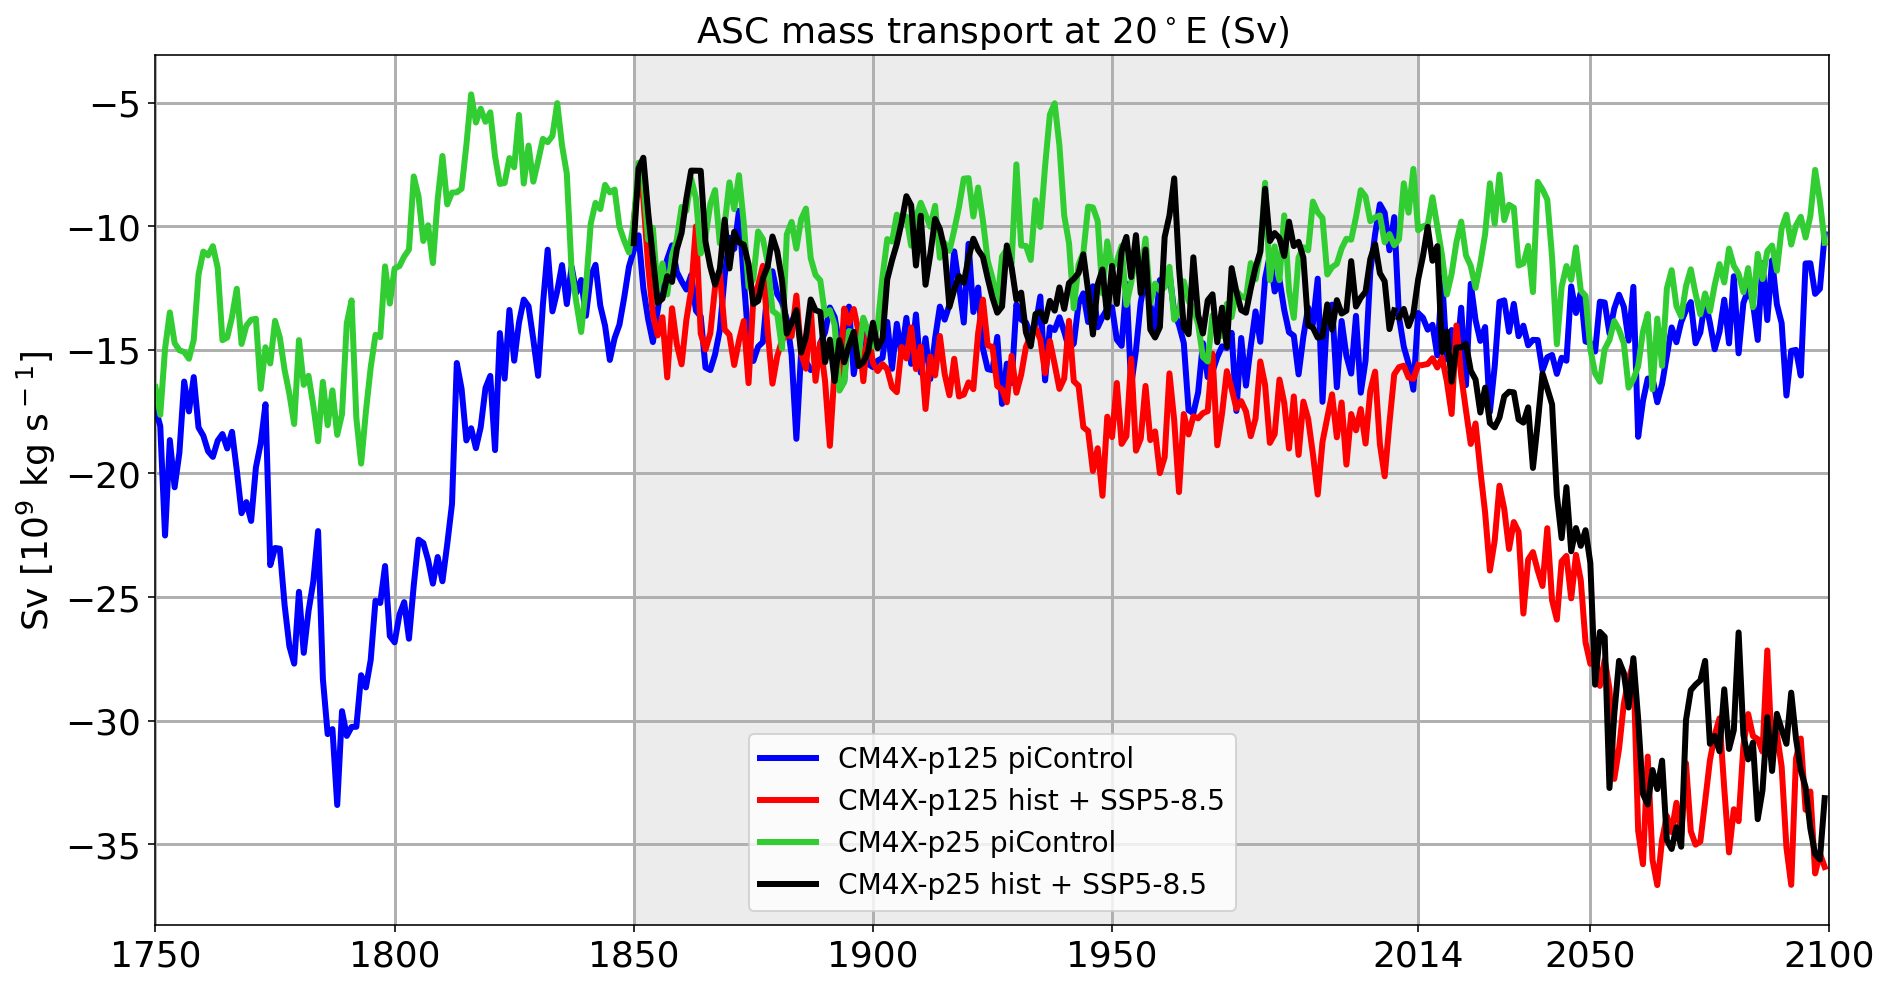

In [41]:
%%time
fig, ax = plt.subplots(figsize=(15,8))

### p125
plt.plot(asc_20e_p125_cntrl_time,asc_20e_p125_cntrl,color='blue',linewidth=3, label = 'CM4X-p125 piControl')
### There is no need to plot p125 hist 1 now .... see CM4x documentation notes.
#plt.plot(asc_20e_p125_hist1_time,asc_20e_p125_hist1,color='grey',linewidth=2, label = 'CM4X-p125 hist1')
plt.plot(asc_20e_p125_hist2_time,asc_20e_p125_hist2,color='red',linewidth=3)
plt.plot(asc_20e_p125_SSP585_time,asc_20e_p125_SSP585,color='red',linewidth=3, label = 'CM4X-p125 hist + SSP5-8.5')

### p25
plt.plot(asc_20e_p25_cntrl_time,asc_20e_p25_cntrl,color='limegreen',linewidth=3, label = 'CM4X-p25 piControl')
plt.plot(asc_20e_p25_hist_time,asc_20e_p25_hist,color='k',linewidth=3, label = 'CM4X-p25 hist + SSP5-8.5')
plt.plot(asc_20e_p25_SSP585_time,asc_20e_p25_SSP585,color='k',linewidth=3)


plt.xlim(1750,2100)
plt.grid(linewidth=1.5, linestyle='-')

## add details including horizontal spanned shading for historical period
## and labels / fontsizes etc.
y1_hist = 1850
y2_hist = 2014
plt.axvspan(y1_hist, y2_hist, color='grey', alpha=0.15, lw=0)
plt.xlim(1750,2100)
plt.grid(linewidth=1.5, linestyle='-')
plt.xticks(ticks=[1750, 1800, 1850, 1900, 1950, 2014, 2050, 2100])
ax.set_ylabel('Sv [10$^9$ kg s$^-$$^1$]',fontsize=18)
ax.set_title('ASC mass transport at 20$^\circ$E (Sv)', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

plt.legend(fontsize=14)

fig.savefig('ASC_20E_CM4X_Odiv313_update.pdf', bbox_inches='tight', dpi=400)

### 150E plot

In [48]:
## p125 configurations
asc_150e_p125_cntrl_time = asc_150e_p125_cntrl.drop(labels='time').assign_coords(coords={"time":time_axis_1750_2100})
asc_150e_p125_cntrl_time = asc_150e_p125_cntrl_time.time.dt.year.drop(labels='time')

asc_150e_p125_hist1_time = asc_150e_p125_hist1.drop(labels='time').assign_coords(coords={"time":time_axis_1850_1939})
asc_150e_p125_hist1_time = asc_150e_p125_hist1_time.time.dt.year.drop(labels='time')

asc_150e_p125_hist2_time = asc_150e_p125_hist2.drop(labels='time').assign_coords(coords={"time":time_axis_1850_2015})
asc_150e_p125_hist2_time = asc_150e_p125_hist2_time.time.dt.year.drop(labels='time')

asc_150e_p125_SSP585_time = asc_150e_p125_SSP585.drop(labels='time').assign_coords(coords={"time":time_axis_2015_2100})
asc_150e_p125_SSP585_time = asc_150e_p125_SSP585_time.time.dt.year.drop(labels='time')

## p25 configurations
asc_150e_p25_cntrl_time = asc_150e_p25_cntrl.drop(labels='time').assign_coords(coords={"time":time_axis_1750_2100})
asc_150e_p25_cntrl_time = asc_150e_p25_cntrl_time.time.dt.year.drop(labels='time')

asc_150e_p25_hist_time = asc_150e_p25_hist.drop(labels='time').assign_coords(coords={"time":time_axis_1850_2010})
asc_150e_p25_hist_time = asc_150e_p25_hist_time.time.dt.year.drop(labels='time')

asc_150e_p25_SSP585_time = asc_150e_p25_SSP585.drop(labels='time').assign_coords(coords={"time":time_axis_2010_2100})
asc_150e_p25_SSP585_time = asc_150e_p25_SSP585_time.time.dt.year.drop(labels='time')

CPU times: user 2min 23s, sys: 54.7 s, total: 3min 18s
Wall time: 6min 47s


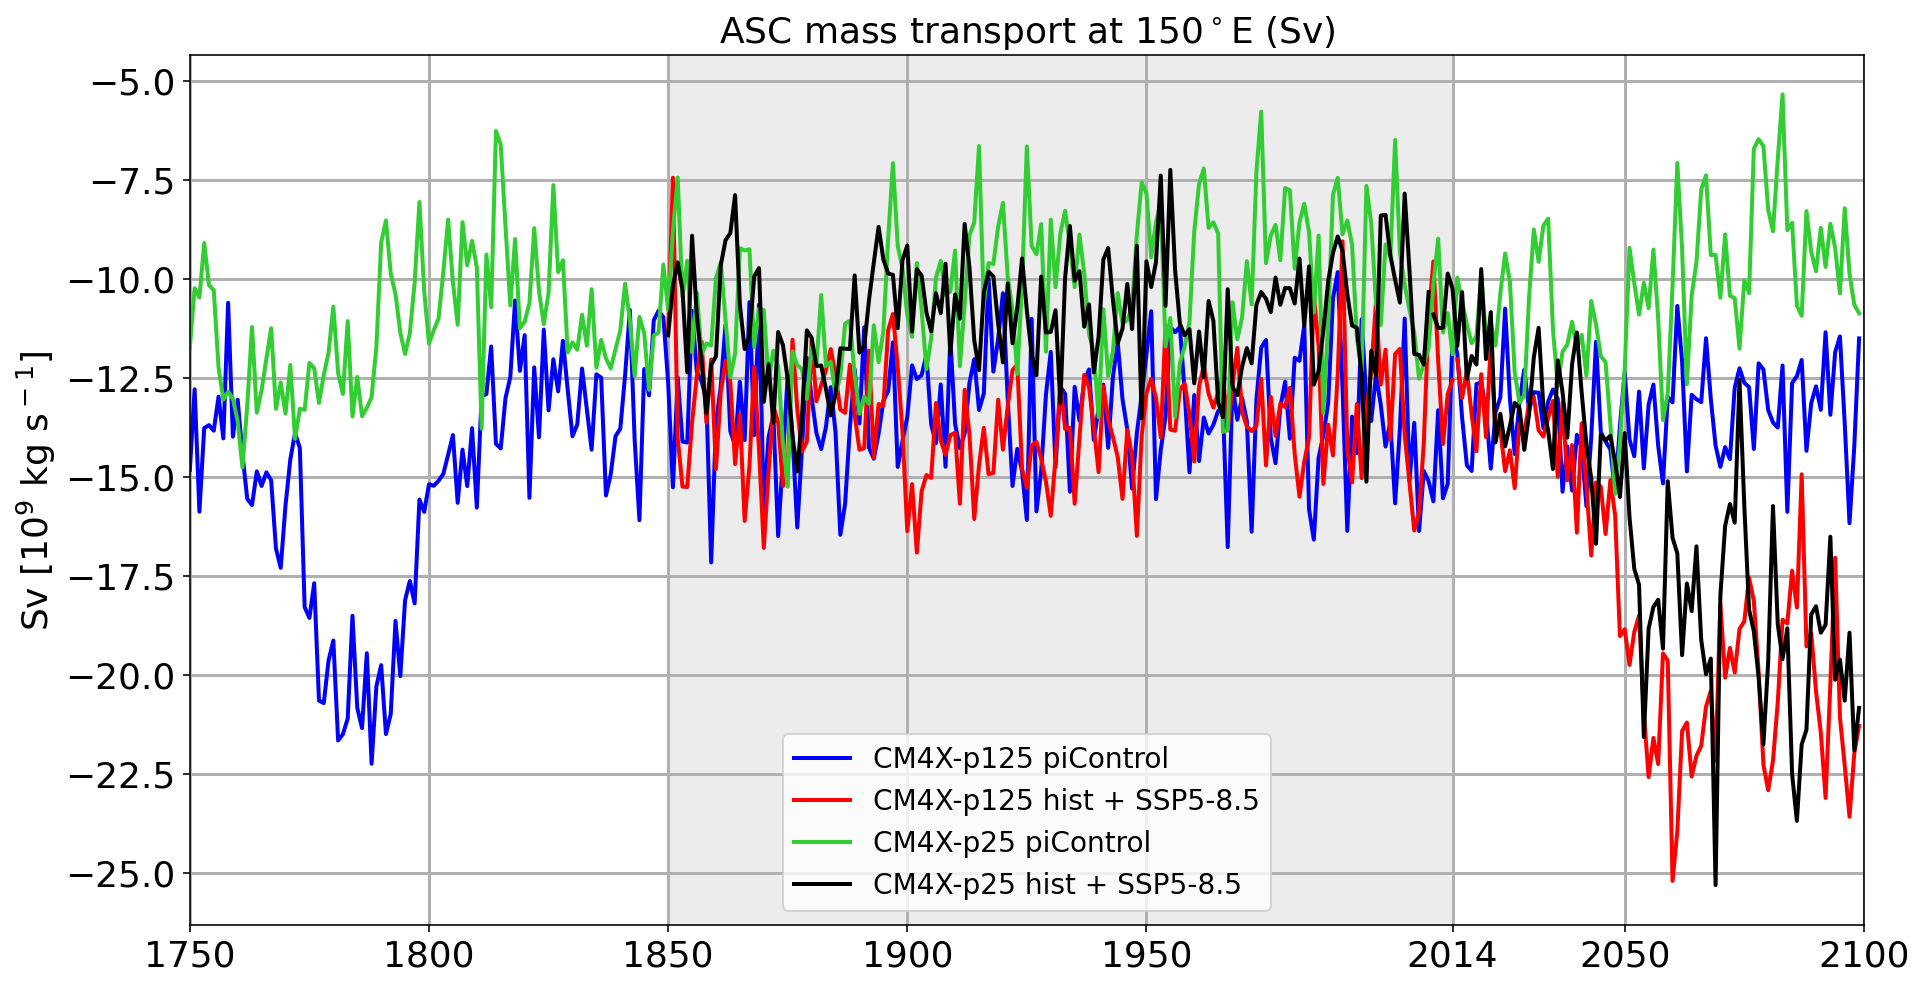

In [49]:
%%time
fig, ax = plt.subplots(figsize=(15,8))
## p125
plt.plot(asc_150e_p125_cntrl_time,asc_150e_p125_cntrl,color='blue',linewidth=2, label = 'CM4X-p125 piControl')
### There is no need to plot p125 hist 1 now .... see CM4x documentation notes.
#plt.plot(asc_150e_p125_hist1_time,asc_150e_p125_hist1,color='grey',linewidth=2, label = 'CM4X-p125 hist1')
plt.plot(asc_150e_p125_hist2_time,asc_150e_p125_hist2,color='red',linewidth=2)
plt.plot(asc_150e_p125_SSP585_time,asc_150e_p125_SSP585,color='red',linewidth=2, label = 'CM4X-p125 hist + SSP5-8.5')

## p25

plt.plot(asc_150e_p25_cntrl_time,asc_150e_p25_cntrl,color='limegreen',linewidth=2, label = 'CM4X-p25 piControl')
plt.plot(asc_150e_p25_hist_time,asc_150e_p25_hist,color='k',linewidth=2, label = 'CM4X-p25 hist + SSP5-8.5')
plt.plot(asc_150e_p25_SSP585_time,asc_150e_p25_SSP585,color='k',linewidth=2)


## add details including horizontal spanned shading for historical period
## and labels / fontsizes etc.
y1_hist = 1850
y2_hist = 2014
plt.axvspan(y1_hist, y2_hist, color='grey', alpha=0.15, lw=0)
plt.xlim(1750,2100)
plt.grid(linewidth=1.5, linestyle='-')
plt.xticks(ticks=[1750, 1800, 1850, 1900, 1950, 2014, 2050, 2100])
ax.set_ylabel('Sv [10$^9$ kg s$^-$$^1$]',fontsize=18)
ax.set_title('ASC mass transport at 150$^\circ$E (Sv)', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)


plt.legend(fontsize=14)

fig.savefig('ASC_150E_CM4X_Odiv313_update.pdf', bbox_inches='tight', dpi=400)

### 130W plot

In [42]:
## p125 configurations
asc_130w_p125_cntrl_time = asc_130w_p125_cntrl.drop(labels='time').assign_coords(coords={"time":time_axis_1750_2100})
asc_130w_p125_cntrl_time = asc_130w_p125_cntrl_time.time.dt.year.drop(labels='time')

asc_130w_p125_hist1_time = asc_130w_p125_hist1.drop(labels='time').assign_coords(coords={"time":time_axis_1850_1939})
asc_130w_p125_hist1_time = asc_130w_p125_hist1_time.time.dt.year.drop(labels='time')

asc_130w_p125_hist2_time = asc_130w_p125_hist2.drop(labels='time').assign_coords(coords={"time":time_axis_1850_2015})
asc_130w_p125_hist2_time = asc_130w_p125_hist2_time.time.dt.year.drop(labels='time')

asc_130w_p125_SSP585_time = asc_130w_p125_SSP585.drop(labels='time').assign_coords(coords={"time":time_axis_2015_2100})
asc_130w_p125_SSP585_time = asc_130w_p125_SSP585_time.time.dt.year.drop(labels='time')

## p25 configurations
asc_130w_p25_cntrl_time = asc_130w_p25_cntrl.drop(labels='time').assign_coords(coords={"time":time_axis_1750_2100})
asc_130w_p25_cntrl_time = asc_130w_p25_cntrl_time.time.dt.year.drop(labels='time')

asc_130w_p25_hist_time = asc_130w_p25_hist.drop(labels='time').assign_coords(coords={"time":time_axis_1850_2010})
asc_130w_p25_hist_time = asc_130w_p25_hist_time.time.dt.year.drop(labels='time')

asc_130w_p25_SSP585_time = asc_130w_p25_SSP585.drop(labels='time').assign_coords(coords={"time":time_axis_2010_2100})
asc_130w_p25_SSP585_time = asc_130w_p25_SSP585_time.time.dt.year.drop(labels='time')

CPU times: user 2min 5s, sys: 1min 14s, total: 3min 20s
Wall time: 6min 43s


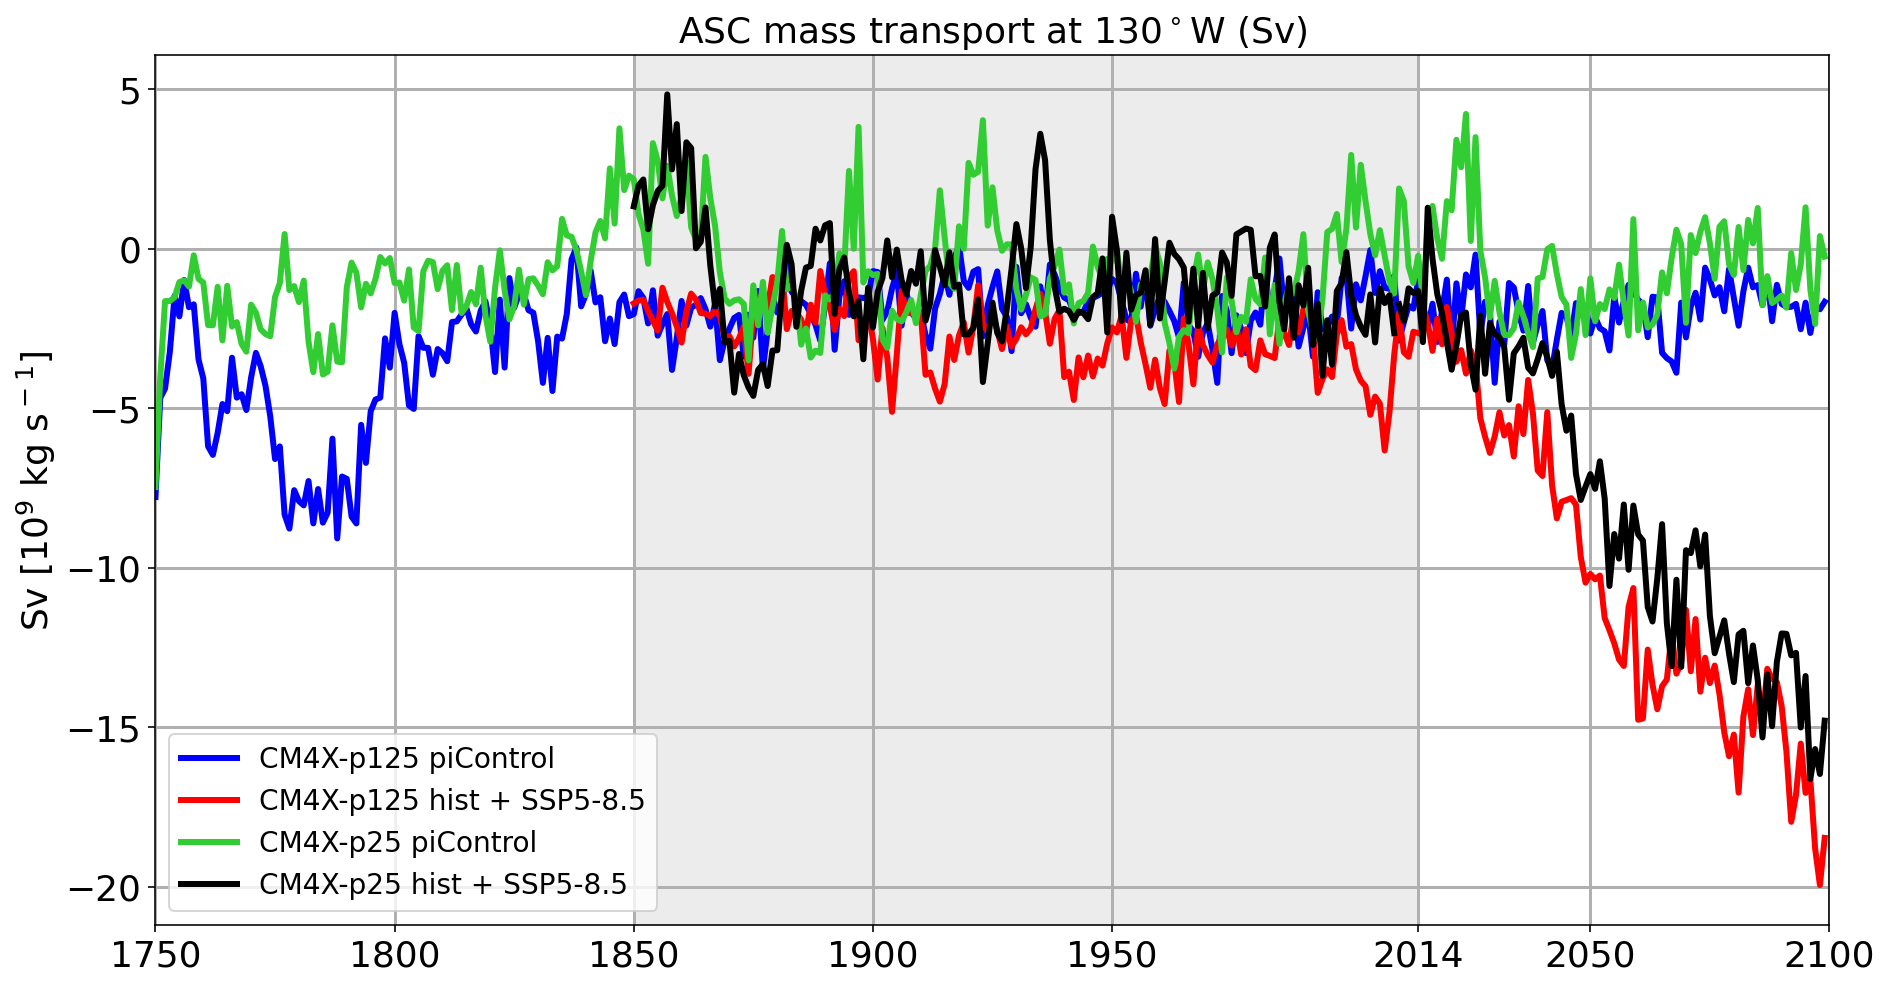

In [43]:
%%time
fig, ax = plt.subplots(figsize=(15,8))
## p125
plt.plot(asc_130w_p125_cntrl_time,asc_130w_p125_cntrl,color='blue',linewidth=3, label = 'CM4X-p125 piControl')
### There is no need to plot p125 hist 1 now .... see CM4x documentation notes.
#plt.plot(asc_130w_p125_hist1_time,asc_130w_p125_hist1,color='grey',linewidth=2, label = 'CM4X-p125 hist1')
plt.plot(asc_130w_p125_hist2_time,asc_130w_p125_hist2,color='red',linewidth=3)
plt.plot(asc_130w_p125_SSP585_time,asc_130w_p125_SSP585,color='red',linewidth=3, label = 'CM4X-p125 hist + SSP5-8.5')

## p25
plt.plot(asc_130w_p25_cntrl_time,asc_130w_p25_cntrl,color='limegreen',linewidth=3, label = 'CM4X-p25 piControl')
plt.plot(asc_130w_p25_hist_time,asc_130w_p25_hist,color='k',linewidth=3, label = 'CM4X-p25 hist + SSP5-8.5')
plt.plot(asc_130w_p25_SSP585_time,asc_130w_p25_SSP585,color='k',linewidth=3)


plt.xlim(1750,2100)
plt.grid(linewidth=1.5, linestyle='-')

## add details including horizontal spanned shading for historical period
## and labels / fontsizes etc.
y1_hist = 1850
y2_hist = 2014
plt.axvspan(y1_hist, y2_hist, color='grey', alpha=0.15, lw=0)
plt.xlim(1750,2100)
plt.grid(linewidth=1.5, linestyle='-')
plt.xticks(ticks=[1750, 1800, 1850, 1900, 1950, 2014, 2050, 2100])
ax.set_ylabel('Sv [10$^9$ kg s$^-$$^1$]',fontsize=18)
ax.set_title('ASC mass transport at 130$^\circ$W (Sv)', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)


plt.legend(fontsize=14)

fig.savefig('ASC_130W_CM4X_Odiv313_update.pdf', bbox_inches='tight', dpi=400)

### 80W plot

In [52]:
## p125 configurations
asc_80W_p125_cntrl_time = asc_80W_p125_cntrl.drop(labels='time').assign_coords(coords={"time":time_axis_1750_2100})
asc_80W_p125_cntrl_time = asc_80W_p125_cntrl_time.time.dt.year.drop(labels='time')

asc_80W_p125_hist1_time = asc_80W_p125_hist1.drop(labels='time').assign_coords(coords={"time":time_axis_1850_1939})
asc_80W_p125_hist1_time = asc_80W_p125_hist1_time.time.dt.year.drop(labels='time')

asc_80W_p125_hist2_time = asc_80W_p125_hist2.drop(labels='time').assign_coords(coords={"time":time_axis_1850_2015})
asc_80W_p125_hist2_time = asc_80W_p125_hist2_time.time.dt.year.drop(labels='time')

asc_80W_p125_SSP585_time = asc_80W_p125_SSP585.drop(labels='time').assign_coords(coords={"time":time_axis_2015_2100})
asc_80W_p125_SSP585_time = asc_80W_p125_SSP585_time.time.dt.year.drop(labels='time')

## p25 configurations
asc_80W_p25_cntrl_time = asc_80W_p25_cntrl.drop(labels='time').assign_coords(coords={"time":time_axis_1750_2100})
asc_80W_p25_cntrl_time = asc_80W_p25_cntrl_time.time.dt.year.drop(labels='time')

asc_80W_p25_hist_time = asc_80W_p25_hist.drop(labels='time').assign_coords(coords={"time":time_axis_1850_2010})
asc_80W_p25_hist_time = asc_80W_p25_hist_time.time.dt.year.drop(labels='time')

asc_80W_p25_SSP585_time = asc_80W_p25_SSP585.drop(labels='time').assign_coords(coords={"time":time_axis_2010_2100})
asc_80W_p25_SSP585_time = asc_80W_p25_SSP585_time.time.dt.year.drop(labels='time')

CPU times: user 3min 28s, sys: 1min 24s, total: 4min 52s
Wall time: 10min 4s


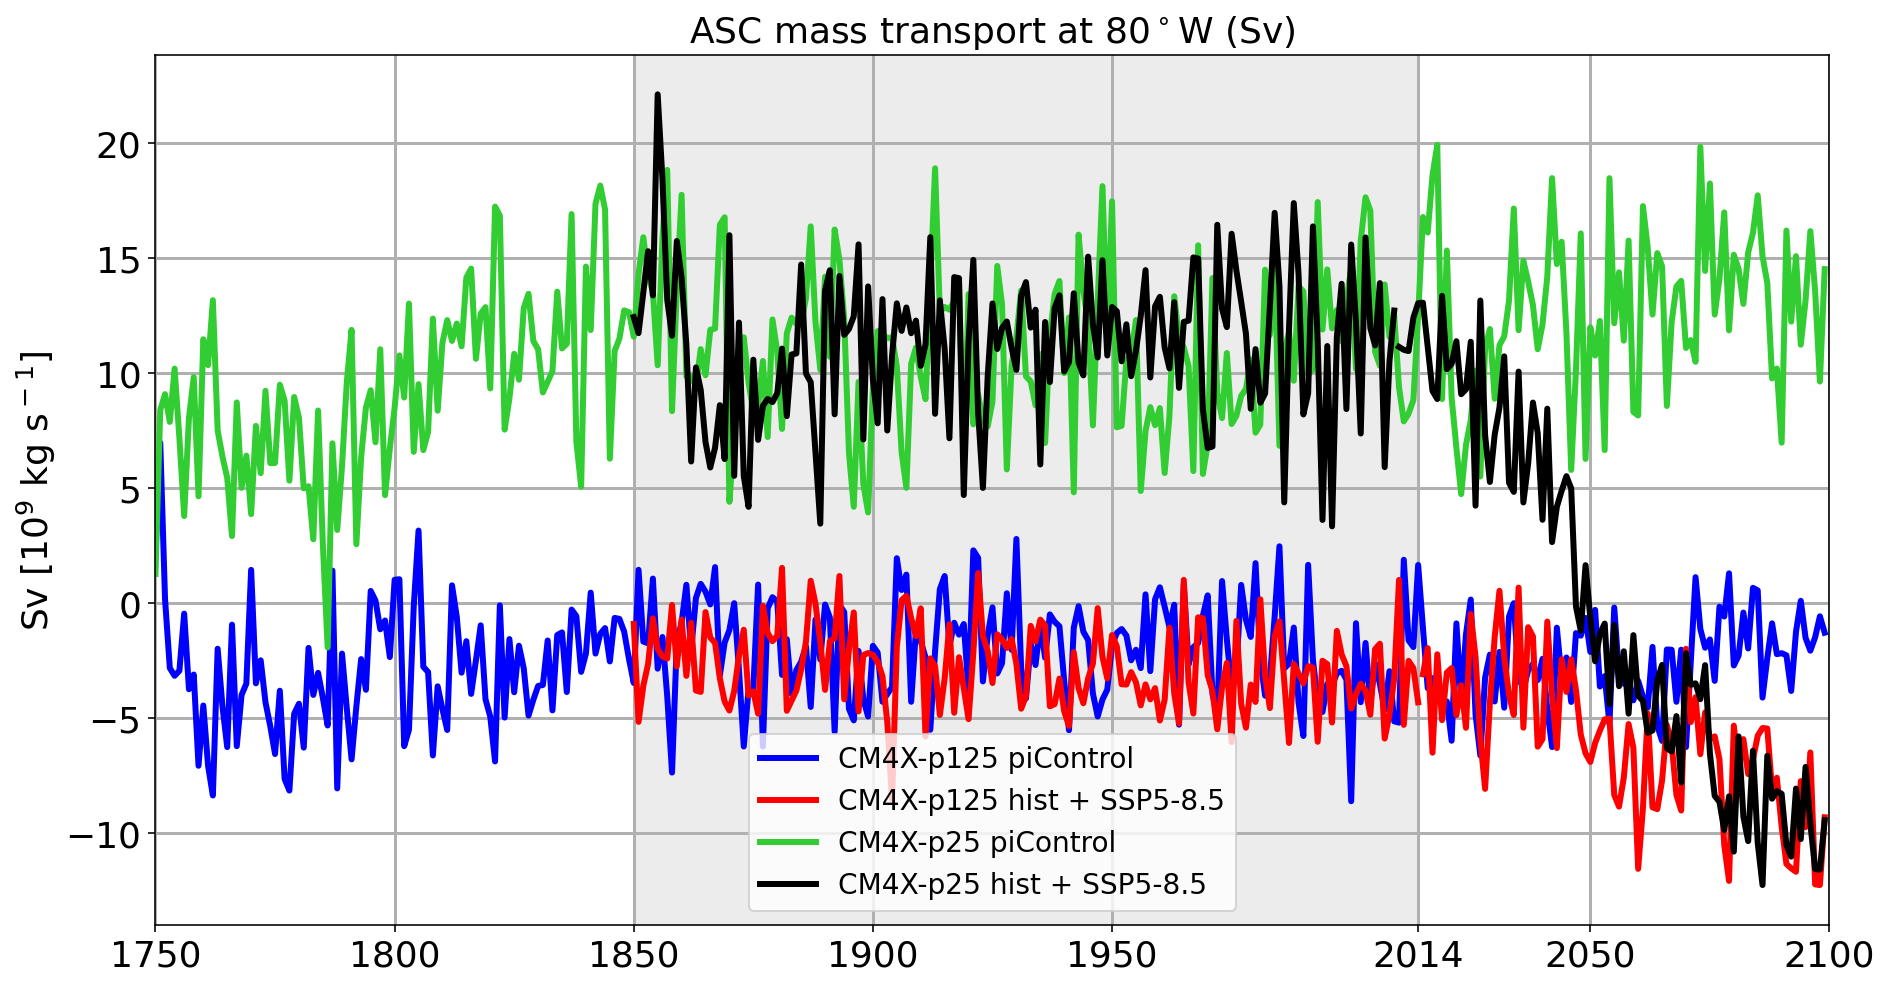

In [53]:
%%time
fig, ax = plt.subplots(figsize=(15,8))
## p125
plt.plot(asc_80W_p125_cntrl_time,asc_80W_p125_cntrl,color='blue',linewidth=3, label = 'CM4X-p125 piControl')
### There is no need to plot p125 hist 1 now .... see CM4x documentation notes.
#plt.plot(asc_80W_p125_hist1_time,asc_80W_p125_hist1,color='grey',linewidth=2, label = 'CM4X-p125 hist1')
plt.plot(asc_80W_p125_hist2_time,asc_80W_p125_hist2,color='red',linewidth=3)
plt.plot(asc_80W_p125_SSP585_time,asc_80W_p125_SSP585,color='red',linewidth=3, label = 'CM4X-p125 hist + SSP5-8.5')

## p25
plt.plot(asc_80W_p25_cntrl_time,asc_80W_p25_cntrl,color='limegreen',linewidth=3, label = 'CM4X-p25 piControl')
plt.plot(asc_80W_p25_hist_time,asc_80W_p25_hist,color='k',linewidth=3, label = 'CM4X-p25 hist + SSP5-8.5')
plt.plot(asc_80W_p25_SSP585_time,asc_80W_p25_SSP585,color='k',linewidth=3)


## add details including horizontal spanned shading for historical period
## and labels / fontsizes etc.
y1_hist = 1850
y2_hist = 2014
plt.axvspan(y1_hist, y2_hist, color='grey', alpha=0.15, lw=0)
plt.xlim(1750,2100)
plt.grid(linewidth=1.5, linestyle='-')
plt.xticks(ticks=[1750, 1800, 1850, 1900, 1950, 2014, 2050, 2100])
ax.set_ylabel('Sv [10$^9$ kg s$^-$$^1$]',fontsize=18)
ax.set_title('ASC mass transport at 80$^\circ$W (Sv)', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)


plt.legend(fontsize=14)

fig.savefig('ASC_80W_CM4X_Odiv313_update.png', bbox_inches='tight', dpi=400)

### Save out timeseries as netcdf for quicker plotting later

In [30]:
asc_cm4x_p125_cntrl = xr.Dataset()
asc_cm4x_p125_cntrl['asc_cntrl_20e'] = asc_20e_p125_cntrl
asc_cm4x_p125_cntrl['asc_cntrl_150e'] = asc_150e_p125_cntrl
asc_cm4x_p125_cntrl['asc_cntrl_130w'] = asc_130w_p125_cntrl
asc_cm4x_p125_cntrl['asc_cntrl_80w'] = asc_80W_p125_cntrl

asc_cm4x_p125_hist = xr.Dataset()
asc_cm4x_p125_hist['asc_cntrl_20e'] = asc_20e_p125_hist2
asc_cm4x_p125_hist['asc_cntrl_150e'] = asc_150e_p125_hist2
asc_cm4x_p125_hist['asc_cntrl_130w'] = asc_130w_p125_hist2
asc_cm4x_p125_hist['asc_cntrl_80w'] = asc_80W_p125_hist2

asc_cm4x_p125_SSP585 = xr.Dataset()
asc_cm4x_p125_SSP585['asc_cntrl_20e'] = asc_20e_p125_SSP585
asc_cm4x_p125_SSP585['asc_cntrl_150e'] = asc_150e_p125_SSP585
asc_cm4x_p125_SSP585['asc_cntrl_130w'] = asc_130w_p125_SSP585
asc_cm4x_p125_SSP585['asc_cntrl_80w'] = asc_80W_p125_SSP585

In [31]:
asc_cm4x_p125_cntrl.to_netcdf('/home/rlb/asc_cm4x_p125_cntrl_timeseries.nc')


KeyboardInterrupt



In [ ]:
asc_cm4x_p125_hist.to_netcdf('/home/rlb/asc_cm4x_p125_hist_timeseries.nc')

In [ ]:
asc_cm4x_p25_cntrl = xr.Dataset()
asc_cm4x_p25_cntrl['asc_cntrl_20e'] = asc_20e_p25_cntrl
asc_cm4x_p25_cntrl['asc_cntrl_150e'] = asc_150e_p25_cntrl
asc_cm4x_p25_cntrl['asc_cntrl_130w'] = asc_130w_p25_cntrl
asc_cm4x_p25_cntrl['asc_cntrl_80w'] = asc_80W_p25_cntrl

asc_cm4x_p25_hist = xr.Dataset()
asc_cm4x_p25_hist['asc_hist_20e'] = asc_20e_p25_hist
asc_cm4x_p25_hist['asc_hist_150e'] = asc_150e_p25_hist
asc_cm4x_p25_hist['asc_hist_130w'] = asc_130w_p25_hist
asc_cm4x_p25_hist['asc_hist_80w'] = asc_80W_p25_hist

asc_cm4x_p25_ssp585 = xr.Dataset()
asc_cm4x_p25_ssp585['asc_hist_20e'] = asc_20e_p25_SSP585
asc_cm4x_p25_ssp585['asc_hist_150e'] = asc_150e_p25_SSP585
asc_cm4x_p25_ssp585['asc_hist_130w'] = asc_130w_p25_SSP585
asc_cm4x_p25_ssp585['asc_hist_80w'] = asc_80W_p25_SSP585

In [ ]:
asc_cm4x_p25_cntrl.to_netcdf('/home/rlb/asc_cm4x_p25_cntrl_timeseries.nc')
asc_cm4x_p25_hist.to_netcdf('/home/rlb/asc_cm4x_p25_hist_timeseries.nc')
asc_cm4x_p25_ssp585.to_netcdf('/home/rlb/asc_cm4x_p25_ssp585_timeseries.nc')